# MarkupLM-based HTML Embedding

MarkupLM is BERT, but applied to HTML pages instead of raw text documents. The model incorporates additional embedding layers to improve performance. [Reference](https://huggingface.co/docs/transformers/main/en/model_doc/markuplm)

## MarkupLM Embedding Demo

**MarkupLMProcessor** combines feature extractor (MarkupLMFeatureExtractor) and a tokenizer (MarkupLMTokenizer or MarkupLMTokenizerFast)
- feature extractor is used to extract all nodes and xpaths from the HTML strings, which are then provided to the tokenizer
- tokenizer converts them to token-level `input_ids, attention_mask, token_type_ids, xpath_subs_seq, xpath_tags_seq`

**MarkupLM Key Parameters**
- `hidden_size` (int, optional, defaults to 768-base/1024-large) — Dimensionality of the encoder layers and the pooler layer.
- `max_position_embeddings` (int, optional, defaults to 512) — The maximum sequence length that this model might ever be used with.


**Model Output Convertion**: Token-level `last_hidden_layer` --> Page-level Vector
- [Mean Pooling](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2): Take attention mask into account for correct averaging
- Normalization 

## Build `MarkupLMEmbedding` Class
based on `langchain_core.embeddings` Module

In [3]:
import torch
import torch.nn.functional as F
from typing import Any, Dict, List

from transformers import AutoProcessor, MarkupLMModel
from langchain_core.embeddings import Embeddings
from langchain_core.pydantic_v1 import BaseModel, root_validator

In [4]:
class MarkupLMEmbeddings(BaseModel, Embeddings):
    """MarkupLM embedding models.

    To use, you should have the transformer python package installed

    Example:
        .. code-block:: python

            from transformers import MarkupLMModel, AutoProcessor

            embeddings = MarkupLMEmbeddings()
    """
    model_name: str # "microsoft/markuplm-base"
    client: Any #: :meta private:
    html_processor: Any #: :meta private:

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that MarkupLMEmbedding is loaded."""

        model_name = values.get("model_name")
        try:
            from transformers import MarkupLMModel, AutoProcessor

            model = MarkupLMModel.from_pretrained(model_name)
            processor = AutoProcessor.from_pretrained(model_name)

            values["client"] = model
            values["html_processor"] = processor
            
        except ImportError:
            raise ImportError(
                "Could not import MarkupLM library. "
                "Please install the transformer library to "
                "use this embedding model: pip install transformers"
            )
        return values
    
    def _mean_pooling(self, model_output, attention_mask) -> List[float]:
        """ Take attention mask into account for correct averaging
        
        Args:
            model_output: the inferencing output of model
            attention_mask: the attention_mask from HTML processor encoding
            
        Returns:
            normalized document-level tensor embedding
        """
        
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        html_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        
        # normalize embedding
        html_embeddings = F.normalize(html_embeddings, p=2, dim=1)
        return html_embeddings
    
    def embed(self, text: str) -> List[float]:
        """Embed a single HTML document using MarkupLM.

        Args:
            text: The HTML text to embed.

        Returns:
            HTML Document embedding. 
        """

        encoding = self.html_processor(html_strings=text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.client(**encoding)

        # Convert model outputs to embeddings
        embeddings = self._mean_pooling(outputs, encoding['attention_mask'])
    
        return embeddings[0].tolist()


    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed a list of documents using MarkupLM.

        Args:
            texts: The list of texts to embed.

        Returns:
            List of embeddings, one for each text.
        """

        embeddings = [self.embed(text) for text in texts]
        return [list(map(float, e)) for e in embeddings]

    def embed_query(self, text: str) -> List[float]:
        """Embed a query using MarkupLM.

        Args:
            text: The text to embed.

        Returns:
            Embeddings for the text.
        """
        
        return self.embed(text)

## Langchain HTML Embedding
based on `MarkupLMEmbedding`

In [1]:
import os, glob
import matplotlib.pyplot as plt
from PIL import Image

from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import CacheBackedEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Load WebSRC Dataset

In [5]:
%%time

name_space = "auto-mlm-base"
model_name = "microsoft/markuplm-base" # or "microsoft/markuplm-large"

# init embedding models
mlme = MarkupLMEmbeddings(model_name=model_name)

# init Cache-Backed Embedder
lfs = LocalFileStore(os.path.join("./Embeddings", name_space))

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings = mlme, 
    document_embedding_cache = lfs,
    namespace=name_space
)

# init splitter, reserved HTML tags
token_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=0,
    separators=['<[^/<>]+>'], keep_separator=True, is_separator_regex=True
)

# test on batch HTMLs, 519 files from auto vertical 
html_dir = f'../WebSRC/auto/*/processed_data/*.html'
docs = []

for fp in glob.glob(html_dir):
    loader = TextLoader(fp)
    docs.extend(loader.load_and_split(token_splitter))

len(docs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


CPU times: user 2.54 s, sys: 483 ms, total: 3.03 s
Wall time: 4.56 s


4283

In [6]:
docs[:3]

[Document(page_content='<html tid="0"> <body tid="1"> <div class="tab-pane active" id="trim-specs" tid="2"> <div class="specs show-more-container collapsed row" tid="3"> <div class="exterior-interior col-sm-6" tid="4"> <table tid="5"> <thead tid="6"> <tr tid="7"> <td tid="8"> Interior </td> </tr> </thead> <tbody tid="9"> <tr tid="10"> <td class="type" tid="11"> Front head room </td> <td class="spec" tid="12"> 38 " </td> </tr> <tr tid="13"> <td class="type" tid="14"> Rear head room </td> <td class="spec" tid="15"> 38 " </td> </tr> <tr tid="16"> <td class="type" tid="17"> Front shoulder room </td>', metadata={'source': '../WebSRC/auto/03/processed_data/0300542.html'}),
 Document(page_content='<td class="spec" tid="18"> 58 " </td> </tr> <tr tid="19"> <td class="type" tid="20"> Rear shoulder room </td> <td class="spec" tid="21"> 56 " </td> </tr> <tr tid="22"> <td class="type" tid="23"> Front hip room </td> <td class="spec" tid="24"> 54 " </td> </tr> <tr tid="25"> <td class="type" tid="26">

In [7]:
%%time
# construct VectorDB
db = FAISS.from_documents(docs, cached_embedder)

CPU times: user 18min 18s, sys: 21 s, total: 18min 39s
Wall time: 3min 14s


> CPU times: user 16min 26s, sys: 12.2 s, total: 16min 38s, Wall time: 2min 50s

In [8]:
# display_images_with_scores, generated by ChatGPT
def display_images_with_scores(html_paths_scores, columns=3):
    """
    Given a list of tuples containing relative paths to HTML files and associated scores, this function finds
    the PNG images with the same base name in the same directory, loads them, and displays them in a grid layout
    in a Jupyter notebook. Each image is displayed with its filename and score in the title.

    :param html_paths_scores: List of tuples (html_path, score).
    :param columns: Number of columns in the grid.
    """
    # Determine the number of rows needed based on the number of images and desired columns
    rows = len(html_paths_scores) // columns + (len(html_paths_scores) % columns > 0)
    
    # Set up the figure and axes for the grid
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    axs = axs.flatten()  # Flatten the axes array for easy iteration
    
    for idx, (html_path, score) in enumerate(html_paths_scores):
        # Extract the directory and the base file name from the HTML path
        base_dir, html_filename = os.path.split(html_path)
        base_filename = os.path.splitext(html_filename)[0]
        png_filename = f"{base_filename}.png"

        # Construct the path for the PNG file
        png_path = os.path.join(base_dir, png_filename)

        # Load and display the image with the filename and score in the title
        try:
            image = Image.open(png_path)
            axs[idx].imshow(image)
            title = f"{png_filename} - Score: {score}"
            axs[idx].set_title(title, fontsize=10)  # Show the image file name and score as the title
            axs[idx].axis('off')  # Turn off axis numbers
        except FileNotFoundError:
            axs[idx].set_title("File Not Found", fontsize=10)
            axs[idx].axis('off')
        except Exception as e:
            axs[idx].set_title(f"Error: {e}", fontsize=10)
            axs[idx].axis('off')

    # Hide any remaining empty subplots
    for ax in axs[len(html_paths_scores):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# def retrieval helper function, default top_k = 3
def html_retrieval_by_query(query, top_k=3):
    query = f"<p>{query}</p>" # format query with html string
    
    query_embedding = mlme.embed_query(query)
    docs = db.similarity_search_with_score_by_vector(query_embedding, k=top_k)
    display_images_with_scores([(doc[0].metadata['source'], doc[1]) for doc in docs])
    
    return

## Similarity search by vector

calculated by cosine similarity and sorted by the query relevance, scroll down to check the evaluation

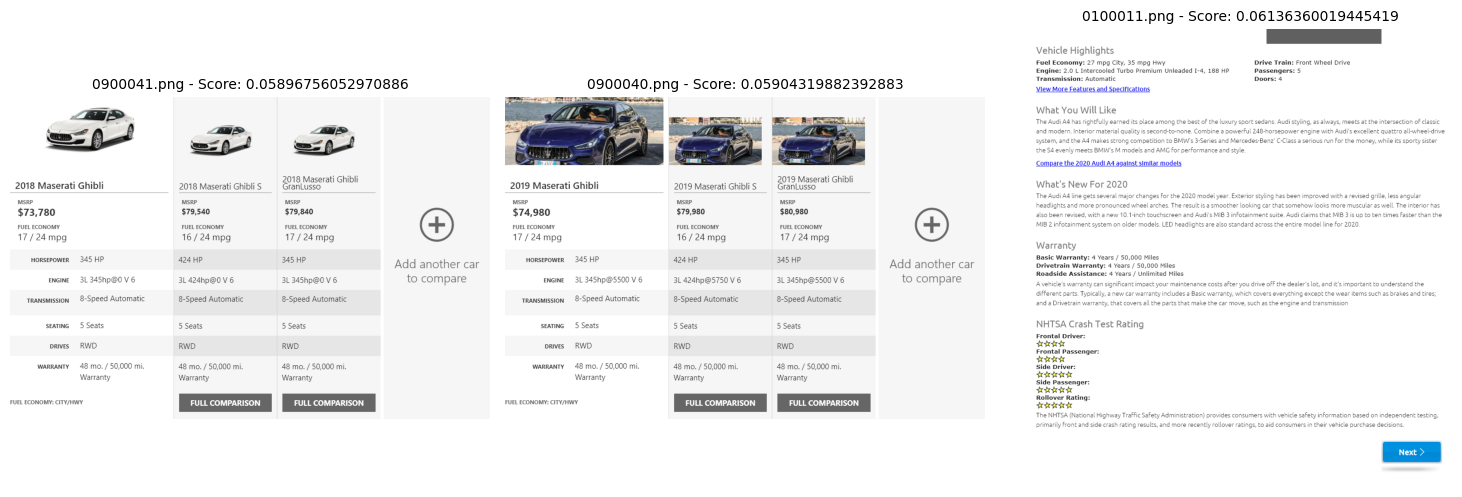

In [9]:
# 0900041
html_retrieval_by_query("How is the engine performance of the '2018 Maserati Ghibli'?") 

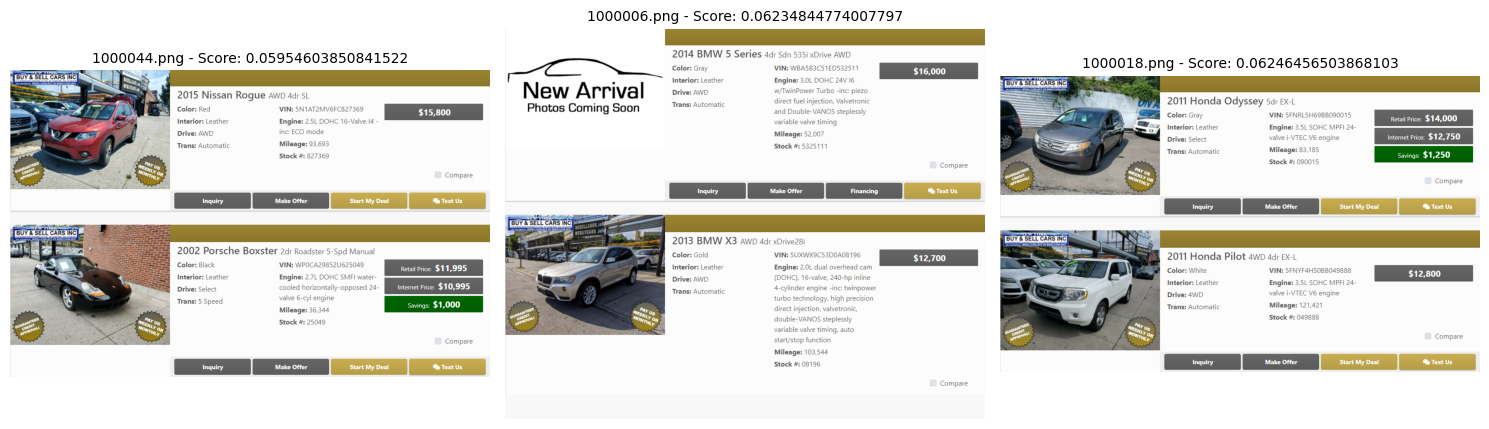

In [10]:
# 1200047
html_retrieval_by_query("The price MSRP of 'Kia Sportage'") 

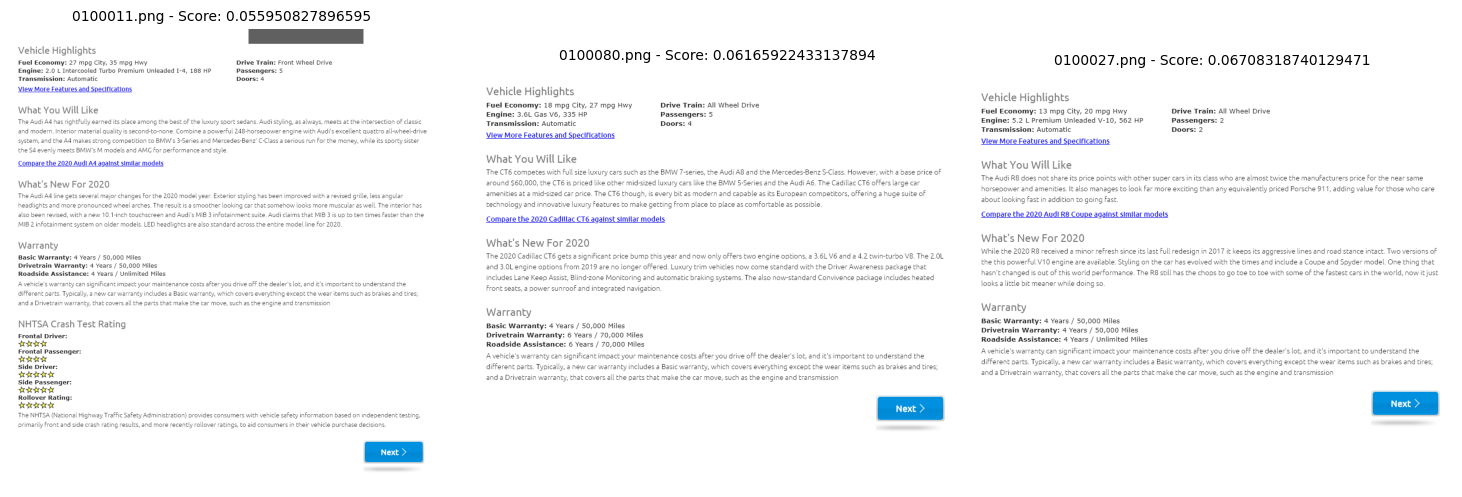

In [11]:
# 0100011
html_retrieval_by_query("Anything new in 2020 for 'Audi A4'") 

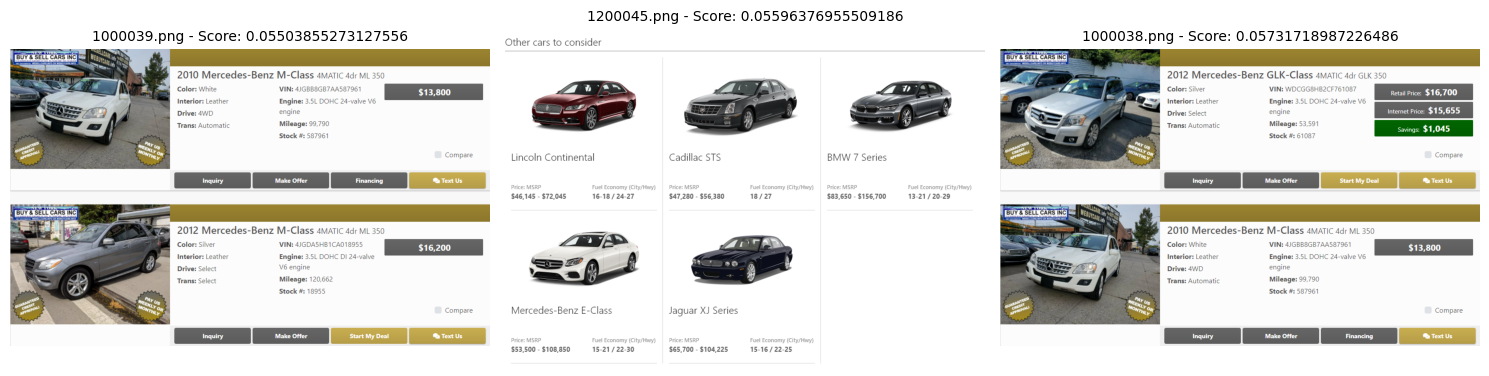

In [12]:
# 1000039
html_retrieval_by_query("The engine of '2012 Mercedes-Benz M-Class'")

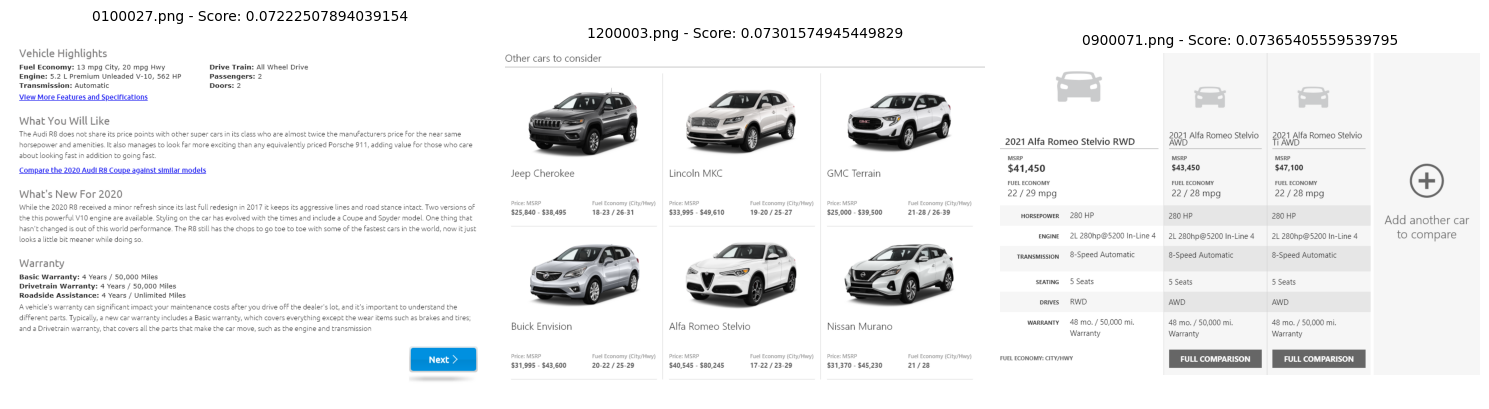

In [13]:
# 0900072
html_retrieval_by_query("Any information about 'Alfa Romeo Stelvio RWD'")

> More complex NL query

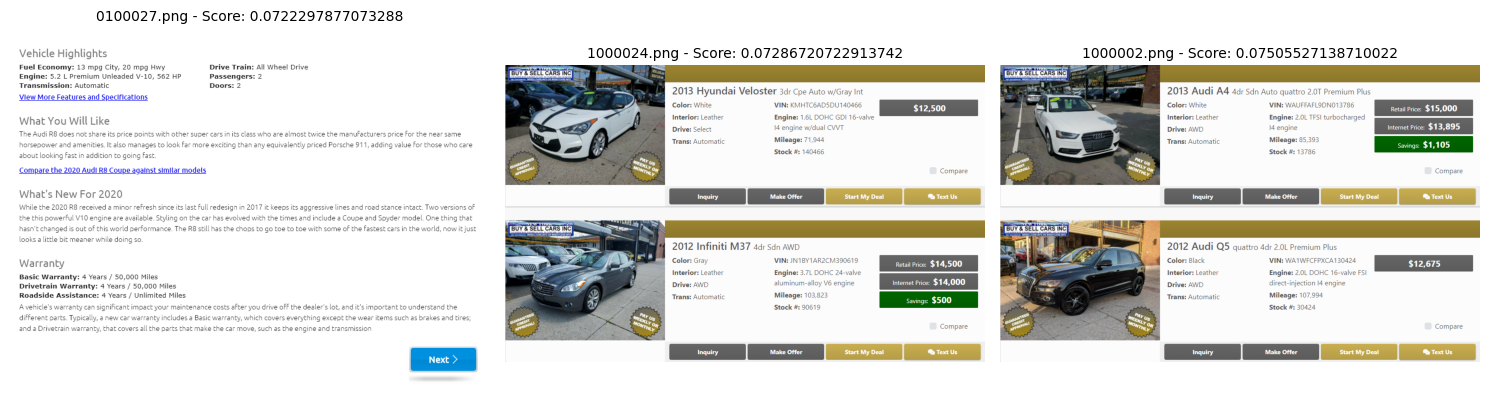

In [14]:
# 1000025
html_retrieval_by_query("For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online?")

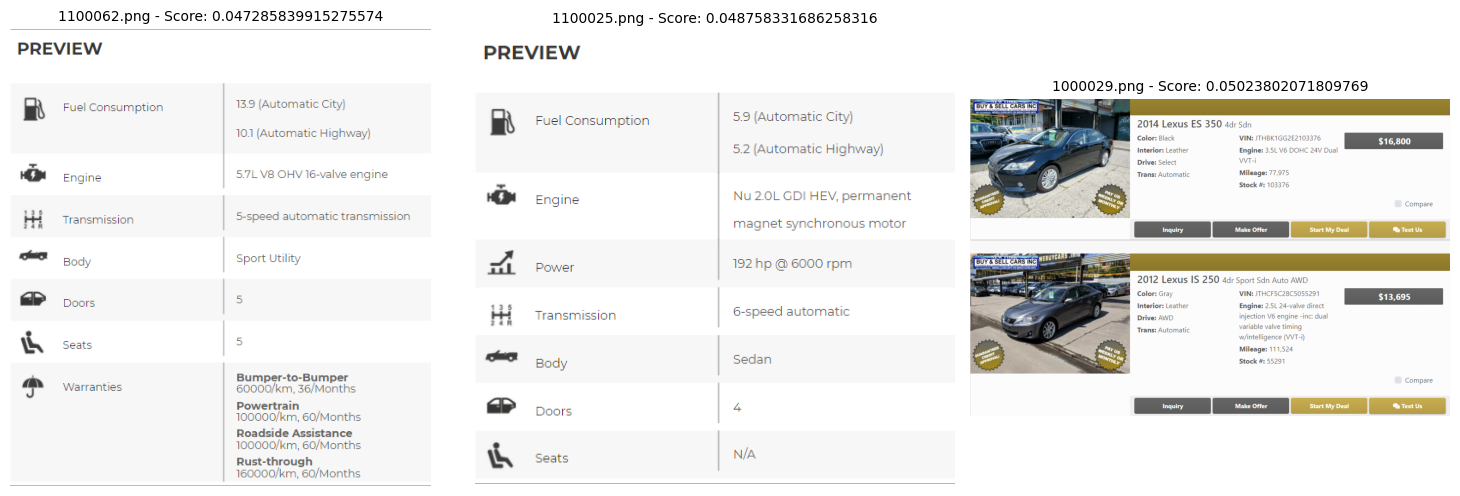

In [15]:
# 1100062
html_retrieval_by_query("What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type?")

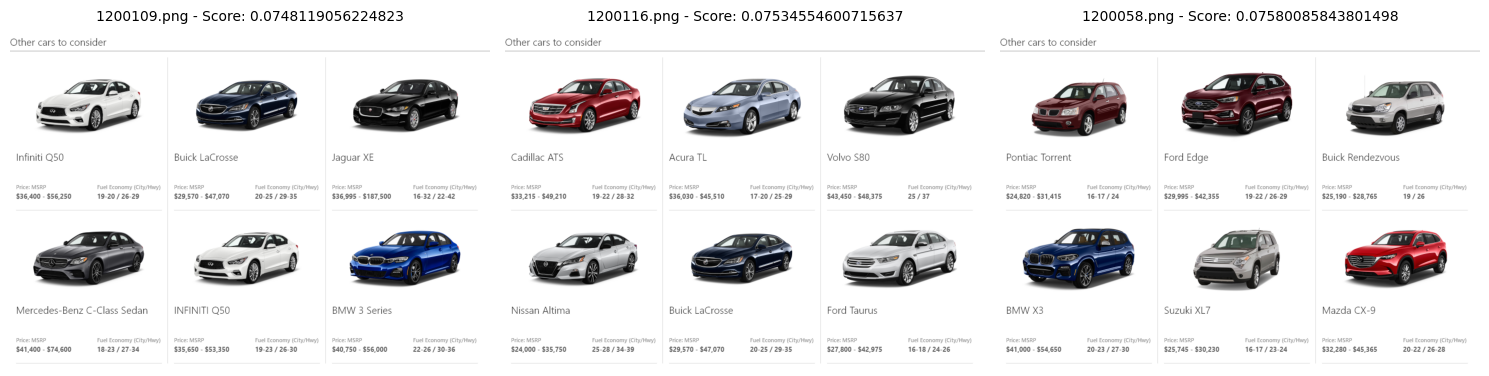

In [16]:
# 1200116
html_retrieval_by_query("A Nissan car with the price MSRP greater than or equal to 24,000")

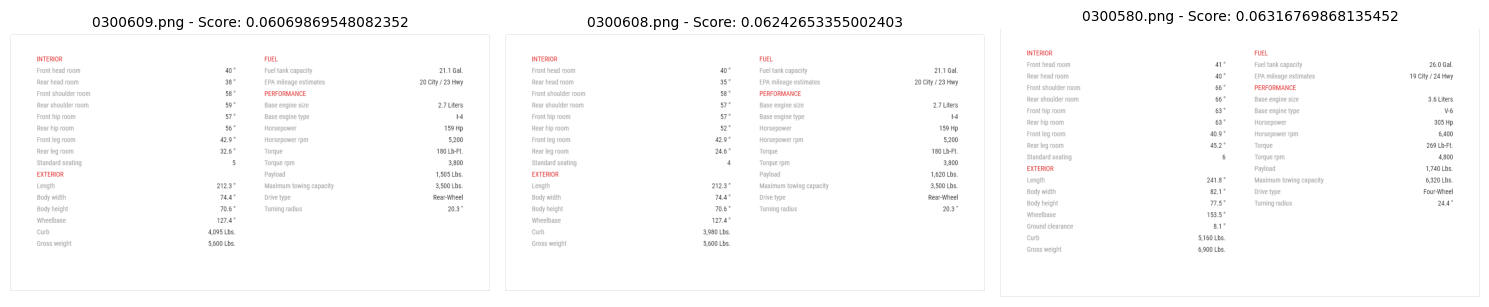

In [17]:
# 0300293
html_retrieval_by_query("Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \"") 

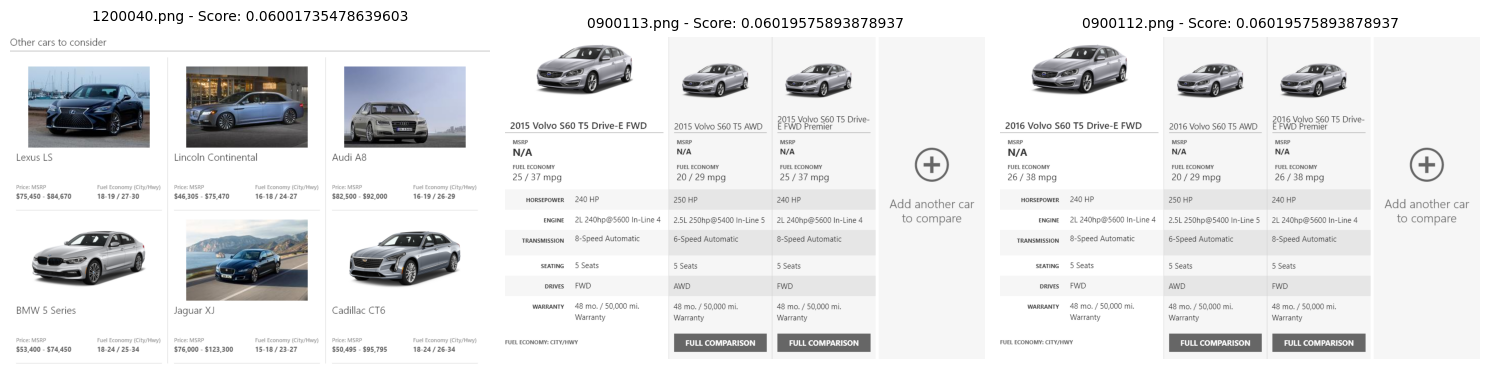

In [18]:
# 1200003
html_retrieval_by_query("For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption?")

## Refined Document-level Top-N Result
| Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| How is the engine performance of the '2018 Maserati Ghibli'? |     ✔️     |     -     |     -    |
| The price MSRP of 'Kia Sportage' |     ❌     |     ❌     |    ❌    |
| Anything new in 2021 for 'Audi A4' |      ✔️     |     -      |     -     |
| The engine of '2012 Mercedes-Benz M-Class' |     ✔️     |     -     |     -     |
| Any information about 'Alfa Romeo Stelvio RWD' |     ❌     |     ❌     |     ✔️     |


| (More complex) Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online? |  ❌      |    ✔️     |     -     |
| What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type? |     ✔️     |     -     |     -    |
| A Nissan car with price MSRP greater than or equal to 24,000  |     ❌     |     ✔️     |     -    |
| Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \" |     ❌     |     ❌     |     ❌    |
| For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption? |  ❌     |    ❌     |     ❌     |
